Imports

In [2]:
# Import necessari
import cv2
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import json
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Canny edge detection

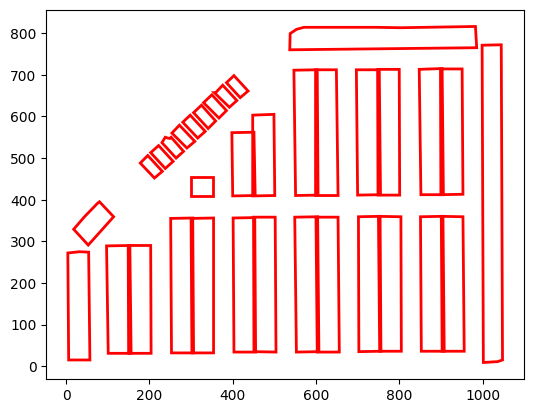

In [14]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches



# Load the JSON data
with open('Dataset_mask/15309700.json', 'r') as f:
    data = json.load(f)

# Extract the shapes from the JSON data
shapes = data['shapes']

# Create a figure and axis
fig, ax = plt.subplots()

# Set the aspect ratio to maintain the original aspect ratio of the image
ax.set_aspect('equal')

# Loop through the shapes and plot them
for shape in shapes:
    label = shape['label']
    points = shape['points']
    
    # Create a polygon patch for the shape
    polygon = patches.Polygon(points, closed=True, fill=False, linewidth=2, edgecolor='r')
    ax.add_patch(polygon)

# Set the axis limits to fit the shapes
ax.relim()
ax.autoscale_view()

# Show the plot
plt.show()

In [56]:
#max mask size
import json
import os

# Define the path to your dataset
dataset_path = 'Dataset_mask'

# Initialize the maximum mask size to 0
max_mask_size = 0

# Iterate over the dataset
for filename in os.listdir(dataset_path):
    if filename.endswith('.json'):
        # Load the JSON file
        with open(os.path.join(dataset_path, filename), 'r') as file:
            data = json.load(file)

        # Iterate over the masks in the JSON file
        for key, value in data.items():
            # Calculate the size of the mask
            mask_size = len(value)
            
            if(mask_size  > 90):
                print(filename)
            # Update the maximum mask size
            max_mask_size = max(max_mask_size, mask_size)

print(f"The maximum mask size in the dataset is: {max_mask_size}")

119422707.json
23289018.json
23289025.json
The maximum mask size in the dataset is: 258


Store canny edge

In [18]:
dataset_path = 'Dataset'
edge_path = 'Dataset_edge'
def get_edge_image(image, low_threshold, high_threshold):
    # Convert the image to grayscale if it's not already
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    
    return edges
#edge detection + padding immagini
for filename in os.listdir(dataset_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        
        input_image_path = os.path.join(dataset_path, filename)
        image = cv2.imread(input_image_path)
        # Ottieni l'immagine del bordo
        edge_image = get_edge_image(image, low_threshold=250, high_threshold=350)
        
        # Apply padding to the edge image
        max_height = 2108
        max_width = 2113
        padding_height = max(0, max_height - edge_image.shape[0])
        padding_width = max(0, max_width - edge_image.shape[1])
        edge_image_padded = cv2.copyMakeBorder(edge_image, 0, padding_height, 0, padding_width, cv2.BORDER_CONSTANT, value=0)
        # Verificare se il nome del file contiene "_testing" o "_training"
        if "_testing" in filename or "_training" in filename:
            # Rinominare il file rimuovendo "_testing" o "_training" dal nome
            new_filename = filename.replace("_testing", "").replace("_training", "")
            
            print(f"Rinominato il file {filename} in {new_filename}")
            # Salva l'immagine del bordo nella cartella di output
            output_image_path = os.path.join(edge_path, new_filename)
            cv2.imwrite(output_image_path, edge_image_padded)

print("Il rilevamento dei bordi è stato applicato a tutte le immagini nella cartella.")


Rinominato il file 1-Estado de Mexico-TEC_training_parcheggi.png in 1-Estado de Mexico-TEC_parcheggi.png
Rinominato il file 1-Guadalajara-TEC_training_parcheggi.png in 1-Guadalajara-TEC_parcheggi.png
Rinominato il file 1-Monterrey-TEC_training_parcheggi.png in 1-Monterrey-TEC_parcheggi.png
Rinominato il file 101881731_training.png in 101881731.png
Rinominato il file 103109948_testing.png in 103109948.png
Rinominato il file 103614205_training.png in 103614205.png
Rinominato il file 104101927_testing.png in 104101927.png
Rinominato il file 104357814_training.png in 104357814.png
Rinominato il file 104357815_training.png in 104357815.png
Rinominato il file 104357817_training.png in 104357817.png
Rinominato il file 104907575_testing.png in 104907575.png
Rinominato il file 116016718_training.png in 116016718.png
Rinominato il file 119422952_training.png in 119422952.png
Rinominato il file 119917133_training.png in 119917133.png
Rinominato il file 126381586_training.png in 126381586.png
Rino

In [19]:
import os
import shutil

# Define the paths to the mask and image folders
mask_folder = 'Dataset_mask'
image_folder = 'Dataset_edge'

# Create a new folder to store the combined images and masks
combined_folder = 'Dataset_combined'
os.makedirs(combined_folder, exist_ok=True)

# Copy all files from the mask folder to the combined folder
for mask_file in os.listdir(mask_folder):
    shutil.copy2(os.path.join(mask_folder, mask_file), combined_folder)

# Copy all files from the image folder to the combined folder
for image_file in os.listdir(image_folder):
    shutil.copy2(os.path.join(image_folder, image_file), combined_folder)

print("Masks and images have been combined and stored in the 'Combined' folder.")

Masks and images have been combined and stored in the 'Combined' folder.


Dataset preparation

DATASET CLASS

In [57]:
import os
import glob
from PIL import Image
class ParkingLotDataset(Dataset):
    def __init__(self, root_dir, pairs=None, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        if pairs is None:
            # Get all image files
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*.png')))

            # Get all mask files
            self.mask_paths = sorted(glob.glob(os.path.join(root_dir, '*.json')))

            # Pair image and mask files based on their filenames
            self.pairs = [(image_path, mask_path) for image_path in self.image_paths for mask_path in self.mask_paths if os.path.splitext(os.path.basename(image_path))[0] == os.path.splitext(os.path.basename(mask_path))[0]]
        else:
            self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        image_path, mask_path = self.pairs[idx]

        # Load image
        image = cv2.imread(image_path)
        # Apply transformations
        if self.transforms:
            image = self.transforms(image)
            print(image.shape)
        #image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load masks
        with open(mask_path, 'r') as f:
            masks_data = json.load(f)

        masks = []
        for shape in masks_data['shapes']:
            points = np.array(shape['points'])
            mask = np.zeros_like(image[:, :, 0])
            cv2.fillPoly(mask, [points.astype(np.int32)], 1)
            masks.append(mask)
        # Pad masks to a fixed size
        max_masks = 258  # Set this to the maximum number of masks you want to allow
        if len(masks) < max_masks:
            masks += [np.zeros_like(image[:, :, 0])] * (max_masks - len(masks))
        elif len(masks) > max_masks:
            masks = masks[:max_masks]

        masks = np.stack(masks, axis=0).astype(np.float32)

        

        return image, masks

DATASET SLPIT

In [58]:
#controllo il massimo valore di altezza e larghezza per fare il padding
import cv2
import os

# Directory containing the images
data_dir = 'Dataset_combined'

# Initialize variables to store max height and width
max_height = 0
max_width = 0

# Iterate through all images in the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Load the image
        image_path = os.path.join(data_dir, filename)
        image = cv2.imread(image_path)

        # Get height and width of the image
        height, width, _ = image.shape

        # Update max_height and max_width if necessary
        if height > max_height:
            max_height = height
        if width > max_width:
            max_width = width

        # Check if the image has different max_height and max_width
        if height != 2108 or width != 2113:
            print("Image with different max_height and max_width:", filename)

#Image with different max_height and max_width: Queretaro-TEC_parcheggi.png
print("Maximum Height:", max_height)
print("Maximum Width:", max_width)

Maximum Height: 2108
Maximum Width: 2113


In [59]:
import random
from torch.utils.data import random_split
from torchvision.transforms import functional as F

# magari rifare il dataloader con due cartelle
image_path = 'Dataset_combined'

target_size = (max_width, max_height)

transform = transforms.Compose([
    
    transforms.ToTensor(),
    # Add other transforms here as needed
])


# Create the dataset
dataset = ParkingLotDataset(image_path, transforms=transform)

# Define the proportions for the split
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1


# Shuffle the dataset
random.shuffle(dataset.pairs)

# Calculate the sizes of each split
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_pairs = dataset.pairs[:train_size]
val_pairs = dataset.pairs[train_size:train_size+val_size]
test_pairs = dataset.pairs[train_size+val_size:]

# Create datasets for each split
train_dataset = ParkingLotDataset(image_path, pairs=train_pairs, transforms=transform)
val_dataset = ParkingLotDataset(image_path, pairs=val_pairs, transforms=transform)
test_dataset = ParkingLotDataset(image_path, pairs=test_pairs, transforms=transform )

# Now you can create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 


torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])
torch.Size([3, 2108, 2113])


TypeError: Invalid shape (3, 2108, 258) for image data

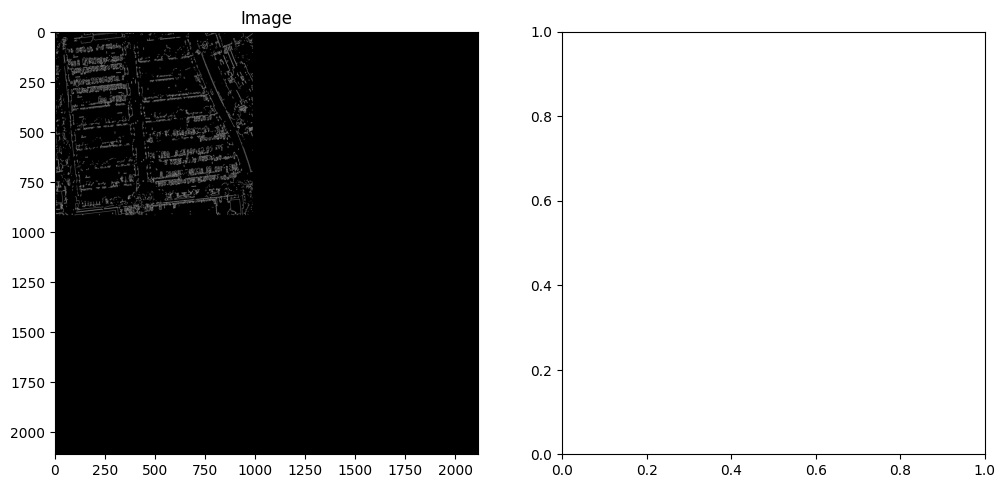

In [60]:
#print delle immagini
import matplotlib.pyplot as plt

# Display images and masks from the train data loader
for images, masks in train_loader:
    for i in range(images.size(0)):
        image = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].permute(1, 2, 0).numpy()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(image)
        ax1.set_title('Image')
        ax2.imshow(mask.squeeze(), cmap='gray')
        ax2.set_title('Mask')
        plt.show()
        break  # Display only one batch
    break  # Display only one batch  

Model

In [54]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import fcn_resnet50


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the model
model = fcn_resnet50(pretrained=False, num_classes=2).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

c:\Users\Federico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Federico\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Federico/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:12<00:00, 8.40MB/s]


TypeError: Unexpected type <class 'numpy.ndarray'>

Train

In [17]:
# Define the number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Training
    model.train()
    for images, targets in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        for images, targets in val_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # You can add here code to compute metrics and print them


NameError: name 'model' is not defined